In [65]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmocean import cm
from datetime import datetime, timedelta
from calendar import monthrange
from salishsea_tools import stormtools, places, geo_tools
from matplotlib.colors import LogNorm
from windrose import WindroseAxes
from tqdm.notebook import tqdm
from glob import glob

%matplotlib inline
plt.rcParams['font.size'] = 12

In [18]:
path = '/home/bmoorema/Desktop/winddata/sentryshoal/'
filelist = sorted(glob(path + 'c*'))

In [22]:
time, wdir, wspd = [], [], []
for file in filelist:
    data = pd.read_csv(file, header=None, chunksize=1)
    gotdate = True
    gotwind = True
    for i, chunk in enumerate(tqdm(data)):
        line = chunk[0][i].strip().split()[:7]
        if line[1] == 'Sentry':
            gotdate = False
        elif gotdate == False:
            gotdate = True
            gotwind = False
            if (int(line[3]) > 2020) & (int(line[3]) < 202020):
                year, month, day = int(line[3][:4]), int(line[3][4:]), int(line[4])
                HHMM = f'{int(line[5]):04d}'
            elif int(line[3]) > 202020:
                year, month, day = int(line[3][:4]), int(line[3][4:6]), int(line[3][6:])
                HHMM = f'{int(line[4]):04d}'
            elif int(line[4]) > 12:
                year = int(line[3])
                MMDD, HHMM = [f'{int(l):04d}' for l in line[4:6]]
                month, day = int(MMDD[:2]), int(MMDD[2:])
            else:
                year = int(line[3])
                HHMM = f'{int(line[6]):04d}'
                month, day = int(line[4]), int(line[5])
            hour, minute = int(HHMM[:2]), int(HHMM[2:])
            time.append(datetime(year, month, day, hour, minute, 0))
        elif gotwind == False:
            gotwind = True
            wdir.append(float(line[0].split('W')[0]))
            wspd.append(float(line[1].split('W')[0]))

# Save output as netCDF
data_vars = {'wspd': ('time', wspd), 'wdir': ('time', wdir)}
coords = {'time': time}
fn_out = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/wind_obs/sentry_shoal.nc'
ds = xr.Dataset(data_vars=data_vars, coords=coords)
ds.to_netcdf(fn_out)

In [79]:
# Specify daterange
daterange = [datetime(2015, 1, 1), datetime(2019, 1, 1)]
subdomain = [100, 170, 110, 190]

# Load HRDPS
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/local/'

# Preallocate storage dictionaries
stations = [
    {'ECname': 'Sandheads'    , 'MOADname': 'Sandheads', 'ji': []},
    {'ECname': 'SistersIsland', 'MOADname': 'Sisters Islet', 'ji': []},
    {'ECname': 'SentryShoal'  , 'MOADname': 'Sentry Shoal', 'ji': []},
]
for station in stations:
    for key in ['obs', 'HRDPS']:
        station[key] = {'spd': np.empty(0), 'dir': np.empty(0), 'time': np.empty(0)}

In [80]:
files = [
    '/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2011m09d21.nc',
    '/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2011m09d22.nc',
    '/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m09d12.nc',
]

for file in files:
    with xr.open_dataset(file) as ds:
        for station in stations:
            station['ji'].append(geo_tools.find_closest_model_point(
                *places.PLACES[station['MOADname']]['lon lat'], ds.nav_lon-360, ds.nav_lat, grid='GEM2.5',
                tols={'NEMO': {'tol_lon': 0.0104, 'tol_lat': 0.00388}, 'GEM2.5': {'tol_lon': 0.015, 'tol_lat': 0.016}},
            ))

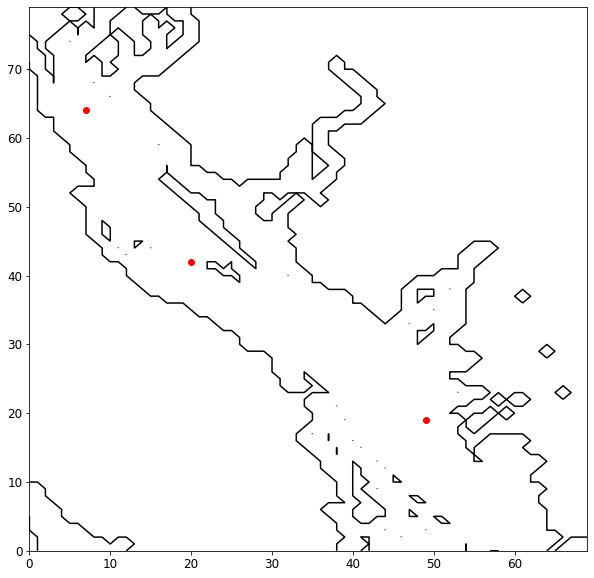

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))
with xr.open_dataset(sorted(glob(path + 'HRDPS*'))[0]) as ds:
    ax.contour(ds.meshmask, levels=[-0.01, 0.01], colors='k')
    for station in stations:
        ax.plot(station['ji'][0][1]-subdomain[0], station['ji'][0][0]-subdomain[2], 'ro')

In [4]:
# Load EC observations over 10 year period
for year in tqdm(range(2010, 2020)):
    for month in range(1, 13):
        
        # Loop through stations
        for station in stations:
            
            # Define month boundaries
            start = datetime(year, month, 1).strftime('%d-%b-%Y')
            end = datetime(year, month, monthrange(year, month)[1]).strftime('%d-%b-%Y')
            
            # Load data into dict
            wspd, wdir, _, wtime, _, _ = stormtools.get_EC_observations(station['ECname'], start, end)
            station['obs']['spd'] = np.concatenate((station['obs']['spd'], wspd))
            station['obs']['dir'] = np.concatenate((station['obs']['dir'], wdir))
            station['obs']['time'] = np.concatenate((station['obs']['time'], wtime))

In [5]:
versions = [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
for file, version in zip(tqdm(sorted(glob(path + 'HRDPS*'))), versions):
    with xr.open_dataset(file) as ds:
    
        # Loop through stations
        for station in stations:

            # Extract u and v along sections
            j, i = station['ji'][version][0]
            u = HRDPS.sel(time=dslc).isel(gridY=j, gridX=i).u_wind.values
            v = HRDPS.sel(time=dslc).isel(gridY=j, gridX=i).v_wind.values
            wtime = HRDPS.sel(time=dslc).time.values.astype('datetime64[s]').astype(datetime)

            # Wind angle
            wdir = 180 * np.arctan2(v, u) / np.pi
            wdir[wdir < 0] = wdir[wdir < 0] + 360
            wdir = wdir - 7

            # Update arrays
            station['HRDPS']['spd'] = np.concatenate((station['HRDPS']['spd'], np.sqrt(u**2 + v**2)))
            station['HRDPS']['dir'] = np.concatenate((station['HRDPS']['dir'], wdir - 7))
            station['HRDPS']['time'] = np.concatenate((station['HRDPS']['time'], wtime))

In [ ]:
subdomain = [100, 170, 110, 190]

***

## Sandheads

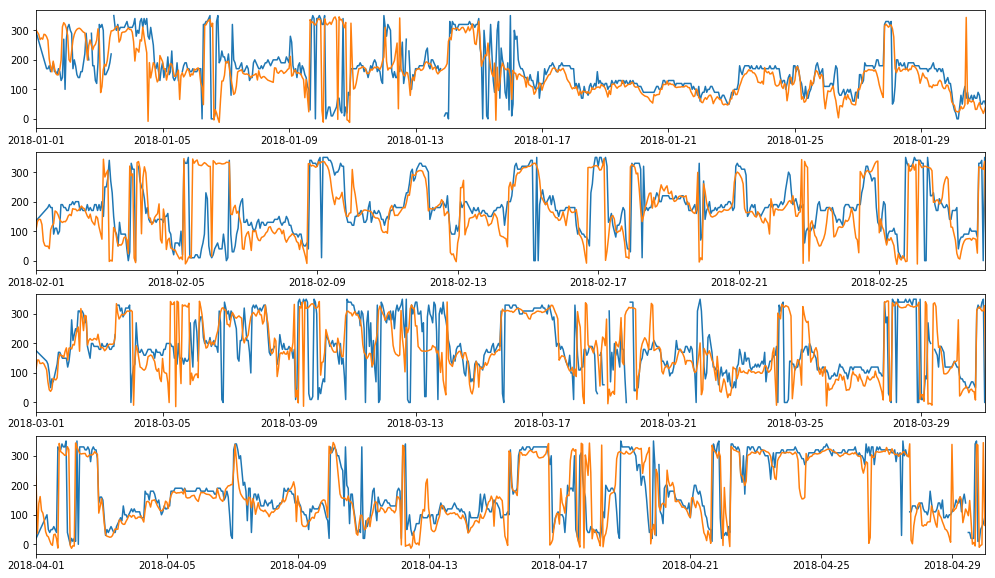

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax, month in zip(axs, range(1, 5)):
    ax.plot(stations[0]['obs']['time'], stations[0]['obs']['dir'])
    ax.plot(stations[0]['HRDPS']['time'], stations[0]['HRDPS']['dir'])
    ax.set_xlim([datetime(2018, month, 1), datetime(2018, month, monthrange(2018, month)[1])])

***

## Sisters Islet

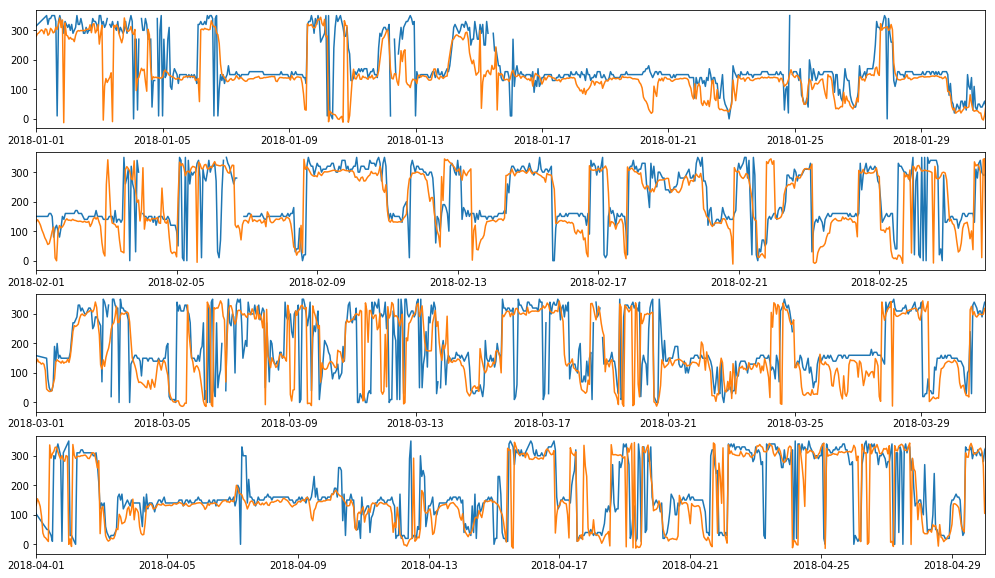

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax, month in zip(axs, range(1, 5)):
    ax.plot(stations[1]['obs']['time'], stations[1]['obs']['dir'])
    ax.plot(stations[1]['HRDPS']['time'], stations[1]['HRDPS']['dir'])
    ax.set_xlim([datetime(2018, month, 1), datetime(2018, month, monthrange(2018, month)[1])])

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


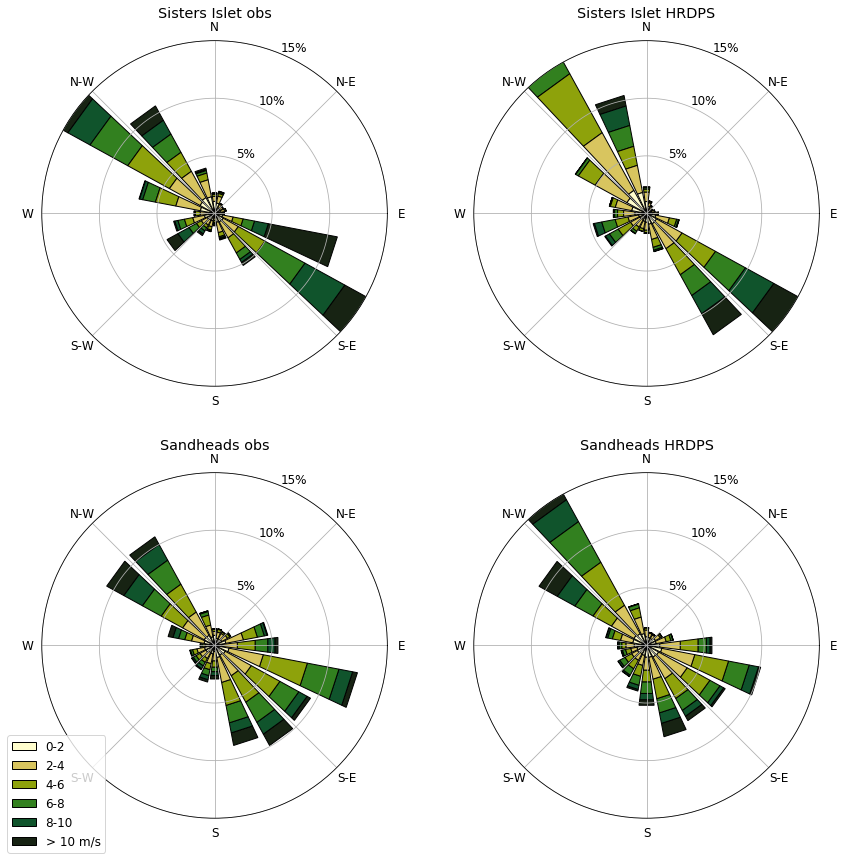

In [6]:
# Make windrose plot using Python Windrose library
# https://windrose.readthedocs.io/en/latest/
#
# Brief example
# ------------------
#
# pip install windrose
#
# from windrose import WindroseAxes
#
# ax = WindroseAxes.from_ax()
# ax.bar(dir, spd, normed=True, opening=0.8, edgecolor='k')
# ax.set_legend()
#
# ------------------

# Plot params
bins = range(0, 11, 2)
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
labels.append(f'> {bins[-1]} m/s')
ticks = [5, 10, 15]

# Make figure
fig = plt.figure(figsize=(12, 12))

# Loop through stations and records
for station, ypos in zip(stations, [0, 0.5]):
    for record, xpos in zip(['obs', 'HRDPS'], [0, 0.5]):

        # Make windrose object
        ax = WindroseAxes.from_ax(fig=fig)
        ax.set_position([xpos, ypos, 0.4, 0.4])
        
        # Plot wind data
        angle = 360 - station[record]['dir'] - 90
        angle[angle < 0] = angle[angle < 0] + 360
        ax.bar(
            angle, station[record]['spd'], bins=bins,
            nsector=20, normed=True, opening=0.8, edgecolor='k', cmap=cm.speed,
        )
        
        # Formatting axis
        ax.set_ylim([0, 15])
        ax.yaxis.set_ticks(ticks)
        ax.yaxis.set_ticklabels([f'{tick}%' for tick in ticks]) # Need because windrose screws this up
        ax.set_title(f"{station['MOADname']} {record}")
        
        # Add legend (hacked to allow custom labels)
        if (ypos == 0) and (xpos == 0):
            l = ax.legend(loc=(-0.1, -0.1))
            for i, label in zip(range(len(labels)), labels):
                l.get_texts()[i].set_text(label)
                     
#fig.savefig('/home/bmoorema/Desktop/ctte_meeting/slides/figures/windroses.pdf', bbox_inches='tight')